In [1]:
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
datapath = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'

df = pd.read_csv(datapath)
df.columns = ['city', 'population', 'violent crime', 'murder', 'rape (new definition)', 'rape (old definition)', 'robbery',
              'aggrevated assault', 'property crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
df = df.drop(df.index[:4])
df['robbery'] = df['robbery'].replace('[^0-9]+', '', regex=True)
df['population'] = df['population'].replace('[^0-9]+', '', regex=True)
df['property crime'] = df['property crime'].replace('[^0-9]+', '', regex=True)
df = df[['population', 'robbery', 'murder', 'property crime']].dropna()
df = df.astype('int64')

In [3]:
df['population_sq'] = (df['population'] * df['population']).apply(lambda x: '%.f' % x)
df['murder'] = np.where(df['murder'] > 0, 1, 0)
df['robbery'] = np.where(df['robbery'] > 0, 1, 0)

display(df.head())

,population,robbery,murder,property crime,population_sq
4,1861,0,0,12,3463321
5,2577,0,0,24,6640929
6,2846,0,0,16,8099716
7,97956,1,1,4090,9595377936
8,6388,1,0,223,40806544


## We are trying to predict property crime. The model that we will use to predict property crime is:
## $$Propertycrime = a + Population + Population^2 + Murder + Robbery$$

To do this, we are going to do four tests:
- Is the prediction linear?
- Is it normally distributed?
- Is the prediction homosedastic?
- Are the features in the prediction lowly correlated?

In [5]:
regr = linear_model.LinearRegression()
Y = df['property crime'].values.reshape(-1, 1)
X = df[['population', 'population_sq', 'murder', 'robbery']]
regr.fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(X, Y))


Coefficients: 
 [[ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]]

Intercept: 
 [-109.57533562]

R-squared:
 0.9961247104988709


According to our model, we can see that property crime is affected by several factors.
- For roughly 15 reports of murder, property crime goes <b>up</b> by one.
- For roughly 96 reports of robbery, property crime goes <b>down</b> by one.
- As population increases by about 33 people, proprerty crime goes <b>up</b> by one.
- As population^2 increases by about 5,000,000, property crime goes <b>down</b> by one.

From this information, we can see that property crime increases faster from murder than robbery, and as population goes up, the number of property crime goes up as well.  
Also something to note is that the y-intercept in our model is a negative value, so 110 worth of property crimes must occur before an actual property crime actually happens. 

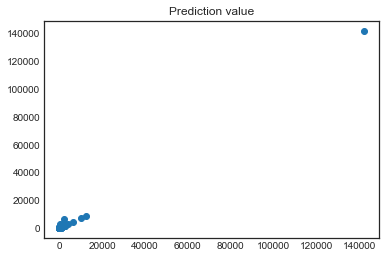

In [6]:
#check if line plot is linear
outcome = Y
predicted = regr.predict(X).ravel()

sns.set_style('white')
plt.scatter(outcome, predicted)
plt.title('Prediction value')
plt.show()

While the scatter plot looks linear, due to an outlier value, we can't verify this information. 

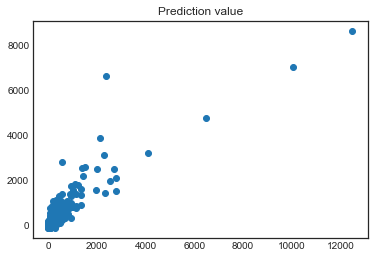

In [20]:
feature = pd.DataFrame(np.column_stack([outcome, predicted]), columns=(['outcome', 'predicted']))
feature = feature[feature['outcome'] < 120000]

plt.scatter(feature.outcome, feature.predicted)
plt.title('Prediction value')
plt.show()

By removing the outlier data, we can see that there is a linear relationship between the features and the outcome.

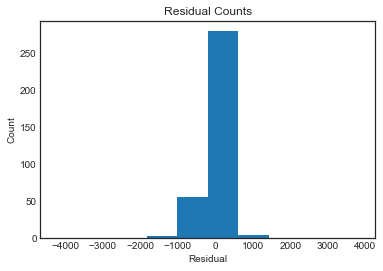

In [7]:
#check if plot has normal distribution
actual = df['property crime']
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts'T
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

It looks like it COULD be normally distributed. Maybe the range is just so large that it is not normally distributed.

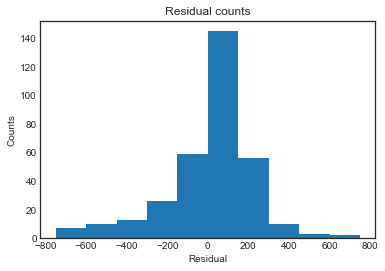

In [24]:
plt.hist(residual, range=(-750, 750))
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Counts')
plt.show()

By limiting the counts of the residual from -750 to 750, we can see that it is normally distributed.

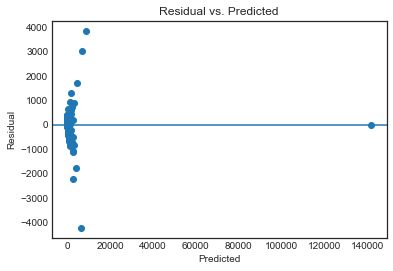

In [9]:
#check if errors are consistent for all predicted values
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

It's a little hard to see the data because of an outlier. How does this look without it?

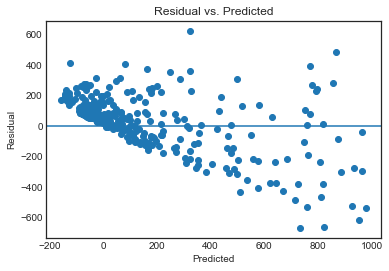

In [43]:
df['predicted'] = predicted
df['residual'] = actual - predicted
outlier_removed = pd.DataFrame()

outlier_removed = df[df['predicted'] < 1000]
plt.scatter(outlier_removed.predicted, outlier_removed.residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Next, let's check if the features are correlated

,population,murder,robbery
population,1.000,0.162,0.064
murder,0.162,1.000,0.313
robbery,0.064,0.313,1.000


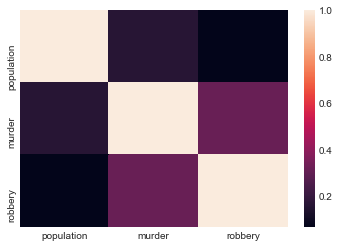

In [44]:
#check if features aren't correlated or not really correlated
correlation_matrix = X.corr()
display(correlation_matrix)
sns.heatmap(X.corr())